- сервис по предсказанию цен для 1000 товаров
- задача максимальных продаж без провисания маржи
- прогнозируемый отрезок времени: декабрь 2019 года

### Data exploration

In [1]:
import numpy as np
import pandas as pd
import requests
import time
import uuid
from tqdm import tqdm
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime, timedelta, date

In [2]:
transactions = pd.read_csv('transactions.csv')

transactions

,dates,SKU,user,price
0,2018-11-09,16019,44796,1252.0
1,2018-11-09,16019,44510,1252.0
2,2018-11-09,16019,19074,1252.0
3,2018-11-09,16019,34472,1252.0
4,2018-11-10,16019,48407,1252.0
...,...,...,...,...
1334255,2019-04-21,16663,20223,2240.0
1334256,2019-04-21,16663,25555,2240.0
1334257,2019-04-21,16663,47340,2240.0
1334258,2019-04-21,16663,23762,2240.0


In [3]:
sku_dict = pd.read_csv('sample_1000.csv')

sku_dict

,sku_id,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date
0,16663,Z8,Z81,Z8100,Z810000,FI3ASO,THSTSG81,2018-06-26,2019-04-21 00:00:00
1,91775,Q5,Q51,Q5100,Q510008,4O4WSH,WKXRWTP7,2019-07-07,2200-01-01 00:00:00
2,24641,ZR,ZR1,ZR100,ZR10000,71SM2O,J8XKU94W,2019-05-22,2200-01-01 00:00:00
3,84184,UA,UA1,UA102,UA10205,FI3ASO,5IEJMU4O,2018-04-19,2019-06-19 00:00:00
4,21070,XG,XG1,XG100,XG10000,4O4WSH,4WL34OA2,2019-06-27,2200-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...
995,76988,UA,UA1,UA100,UA10000,UH2WWF,484JDFU5,2018-03-08,2019-08-10 00:00:00
996,30482,UA,UA1,UA100,UA10006,4HJSP5,8QJHUA65,2019-03-19,2200-01-01 00:00:00
997,85915,BJ,BJ1,BJ102,BJ10201,AO59EQ,VMB2NPY2,2018-03-02,2019-07-05 00:00:00
998,39544,G9,G91,G9101,G910107,B4TA32,79VL731U,2019-05-11,2200-01-01 00:00:00


In [4]:
promo_df = pd.read_csv('promo_df.csv')

promo_df

,SKU,week_num,year,discount
0,74430,1,2018,0.15
1,69978,1,2018,0.05
2,81955,1,2018,0.15
3,78953,1,2018,0.10
4,43034,1,2018,0.05
...,...,...,...,...
2337,35645,52,2019,0.15
2338,81314,52,2019,0.05
2339,75661,52,2019,0.05
2340,38664,52,2019,0.05


In [5]:
canc_df = pd.read_csv('canc_df.csv')

canc_df

,year,week_num,SKU,ret_net_1_price,ret_net_2_price,ret_net_3_price
0,2019,1,10121,2945.681342,2965.743797,2917.394830
1,2019,1,10290,949.466060,942.301292,962.799009
2,2019,1,10973,3751.515022,3735.814981,3709.586540
3,2019,1,11179,3717.042306,3638.799082,3695.090121
4,2019,1,11680,1378.797669,1325.251312,1363.707489
...,...,...,...,...,...,...
10319,2019,52,97659,3409.219608,3394.456244,3434.336572
10320,2019,52,98346,1632.598644,1710.327024,1638.673052
10321,2019,52,98642,1498.441016,1520.235649,1481.583880
10322,2019,52,98774,1649.812737,1638.274072,1725.167364


In [6]:
sales_plan = pd.read_csv('sales_plan.csv')

sales_plan

,SKU,year,month,plan,back_bonus
0,10290,2018,2,20.0,120000
1,10290,2018,3,60.0,140000
2,10290,2018,4,70.0,140000
3,10290,2018,5,60.0,140000
4,10290,2018,6,60.0,40000
...,...,...,...,...,...
12207,99996,2019,8,190.0,140000
12208,99996,2019,9,150.0,100000
12209,99996,2019,10,150.0,200000
12210,99996,2019,11,150.0,100000


In [7]:
wholesale_trade_table = pd.read_csv('wholesale_trade_table.csv')

wholesale_trade_table

,SKU,year,week_num,month,cost_price
0,10060,2019,1,12,2211.0
1,10060,2019,15,4,2454.0
2,10060,2019,16,4,2432.0
3,10060,2019,17,4,2449.0
4,10060,2019,18,4,2280.0
...,...,...,...,...,...
61247,99996,2019,48,12,719.0
61248,99996,2019,49,12,680.0
61249,99996,2019,50,12,697.0
61250,99996,2019,51,12,691.0


### Model 1: simple price forecast

In [8]:
sku_list = list(set(transactions['SKU'].tolist()))

In [9]:
start = pd.Timestamp(date(2019, 12, 1))

In [10]:
ans_list = []

for sku in tqdm(sku_list):
    data = transactions[transactions['SKU'] == sku]
    dates = pd.to_datetime(data['dates'])
    data.loc[:, ('dates')] = dates
    data = data.sort_values('dates')
    
    dates = list(set(data['dates'].tolist()))
    dates.sort()
    prices = [data[data['dates'] == d]['price'].mean() for d in dates]
    
    data = pd.DataFrame()
    data['dates'] = dates
    data['price'] = prices
    
    extender = pd.DataFrame()
    period = (start - data['dates'].min()).days
    extender['dates'] = [data['dates'].min() + timedelta(days=1) * n for n in range(period)]
    data = extender.merge(data, how='left', on='dates')
    
    df0 = pd.DataFrame()
    df0['ds'] = data['dates']
    df0['y'] = data['price']

    df1 = pd.DataFrame()
    df1['ds'] = [start + timedelta(days=1) * n for n in range(31)]
    df1['y'] = None

    m = Prophet()
    m.fit(df0);
    forecast = m.predict(df1)
    
    ans = pd.DataFrame()
    ans['dates'] = forecast['ds']
    ans['price'] = forecast['yhat']
    ans['SKU'] = sku
    
    ans_list.append(ans)
    
forecast = pd.concat(ans_list).reset_index(drop=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:33:09 - cmdstanpy - INFO - Chain [1] start processing
11:33:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/1000 [00:01<30:26,  1.83s/it]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:33:10 - cmdstanpy - 

  2%|▏         | 15/1000 [00:10<10:13,  1.61it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:33:18 - cmdstanpy - INFO - Chain [1] start processing
11:33:18 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 16/1000 [00:11<09:39,  1.70it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:33:19 - cm

11:33:27 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 30/1000 [00:19<10:04,  1.60it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:33:28 - cmdstanpy - INFO - Chain [1] start processing
11:33:28 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 31/1000 [00:20<10:42,  1.51it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

11:33:37 - cmdstanpy - INFO - Chain [1] start processing
11:33:37 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 45/1000 [00:29<09:52,  1.61it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:33:38 - cmdstanpy - INFO - Chain [1] start processing
11:33:38 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 46/1000 [00:30<09:51,  1.61it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

11:33:46 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 60/1000 [00:38<08:44,  1.79it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:33:47 - cmdstanpy - INFO - Chain [1] start processing
11:33:47 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 61/1000 [00:39<09:43,  1.61it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

11:33:56 - cmdstanpy - INFO - Chain [1] start processing
11:33:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 75/1000 [00:49<10:22,  1.49it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:33:57 - cmdstanpy - INFO - Chain [1] start processing
11:33:57 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 76/1000 [00:49<10:26,  1.47it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

11:34:06 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 90/1000 [00:58<09:58,  1.52it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:34:07 - cmdstanpy - INFO - Chain [1] start processing
11:34:07 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 91/1000 [00:59<10:17,  1.47it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

11:34:16 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 105/1000 [01:08<08:59,  1.66it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:34:17 - cmdstanpy - INFO - Chain [1] start processing
11:34:17 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 106/1000 [01:09<09:44,  1.53it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:34:30 - cmdstanpy - INFO - Chain [1] start processing
11:34:30 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 120/1000 [01:22<14:28,  1.01it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:34:30 - cmdstanpy - INFO - Chain [1] start processing
11:34:30 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 121/1000 [01:23<12:52,  1.14it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:34:39 - cmdstanpy - INFO - Chain [1] start processing
11:34:39 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▎        | 135/1000 [01:31<09:00,  1.60it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:34:39 - cmdstanpy - INFO - Chain [1] start processing
11:34:39 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▎        | 136/1000 [01:31<08:27,  1.70it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:34:49 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 150/1000 [01:41<09:16,  1.53it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:34:50 - cmdstanpy - INFO - Chain [1] start processing
11:34:50 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 151/1000 [01:42<09:38,  1.47it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:34:59 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▋        | 165/1000 [01:51<09:32,  1.46it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:35:00 - cmdstanpy - INFO - Chain [1] start processing
11:35:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 166/1000 [01:52<09:55,  1.40it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:35:11 - cmdstanpy - INFO - Chain [1] start processing
11:35:11 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 180/1000 [02:03<08:34,  1.59it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:35:12 - cmdstanpy - INFO - Chain [1] start processing
11:35:12 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 181/1000 [02:04<08:32,  1.60it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:35:21 - cmdstanpy - INFO - Chain [1] done processing
 20%|█▉        | 195/1000 [02:13<08:15,  1.62it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:35:21 - cmdstanpy - INFO - Chain [1] start processing
11:35:21 - cmdstanpy - INFO - Chain [1] done processing
 20%|█▉        | 196/1000 [02:13<08:31,  1.57it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:35:31 - cmdstanpy - INFO - Chain [1] start processing
11:35:31 - cmdstanpy - INFO - Chain [1] done processing
 21%|██        | 210/1000 [02:23<09:33,  1.38it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:35:33 - cmdstanpy - INFO - Chain [1] start processing
11:35:33 - cmdstanpy - INFO - Chain [1] done processing
 21%|██        | 211/1000 [02:25<13:58,  1.06s/it]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:35:45 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▎       | 225/1000 [02:37<12:46,  1.01it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:35:46 - cmdstanpy - INFO - Chain [1] start processing
11:35:46 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 226/1000 [02:38<11:47,  1.09it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:36:03 - cmdstanpy - INFO - Chain [1] start processing
11:36:03 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▍       | 240/1000 [02:55<17:43,  1.40s/it]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:36:04 - cmdstanpy - INFO - Chain [1] start processing
11:36:04 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▍       | 241/1000 [02:57<17:05,  1.35s/it]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:36:18 - cmdstanpy - INFO - Chain [1] start processing
11:36:18 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 255/1000 [03:11<09:59,  1.24it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:36:19 - cmdstanpy - INFO - Chain [1] start processing
11:36:19 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 256/1000 [03:11<08:58,  1.38it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:36:29 - cmdstanpy - INFO - Chain [1] start processing
11:36:29 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 270/1000 [03:21<07:58,  1.53it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:36:29 - cmdstanpy - INFO - Chain [1] start processing
11:36:29 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 271/1000 [03:22<07:17,  1.67it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:36:38 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 285/1000 [03:30<06:59,  1.71it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:36:39 - cmdstanpy - INFO - Chain [1] start processing
11:36:39 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 286/1000 [03:31<07:37,  1.56it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:36:48 - cmdstanpy - INFO - Chain [1] start processing
11:36:48 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 300/1000 [03:40<07:04,  1.65it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:36:48 - cmdstanpy - INFO - Chain [1] start processing
11:36:48 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 301/1000 [03:40<07:12,  1.62it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:36:57 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 315/1000 [03:49<07:18,  1.56it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:36:57 - cmdstanpy - INFO - Chain [1] start processing
11:36:58 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 316/1000 [03:50<07:19,  1.56it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:37:06 - cmdstanpy - INFO - Chain [1] start processing
11:37:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 330/1000 [03:58<07:08,  1.56it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:37:07 - cmdstanpy - INFO - Chain [1] start processing
11:37:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 331/1000 [03:59<06:53,  1.62it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:37:16 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▍      | 345/1000 [04:08<07:24,  1.47it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:37:17 - cmdstanpy - INFO - Chain [1] start processing
11:37:17 - cmdstanpy - INFO - Chain [1] done processing
 35%|███▍      | 346/1000 [04:09<07:44,  1.41it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:37:28 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 360/1000 [04:21<07:45,  1.37it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:37:29 - cmdstanpy - INFO - Chain [1] start processing
11:37:29 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 361/1000 [04:21<08:10,  1.30it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:37:37 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 375/1000 [04:30<05:38,  1.85it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:37:39 - cmdstanpy - INFO - Chain [1] start processing
11:37:39 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 376/1000 [04:31<08:04,  1.29it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:37:47 - cmdstanpy - INFO - Chain [1] done processing
 39%|███▉      | 390/1000 [04:39<05:20,  1.91it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:37:47 - cmdstanpy - INFO - Chain [1] start processing
11:37:47 - cmdstanpy - INFO - Chain [1] done processing
 39%|███▉      | 391/1000 [04:39<06:14,  1.63it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:37:57 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 405/1000 [04:50<06:53,  1.44it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:37:58 - cmdstanpy - INFO - Chain [1] start processing
11:37:58 - cmdstanpy - INFO - Chain [1] done processing
 41%|████      | 406/1000 [04:50<06:52,  1.44it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:38:07 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 420/1000 [04:59<05:49,  1.66it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:38:07 - cmdstanpy - INFO - Chain [1] start processing
11:38:07 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 421/1000 [05:00<05:57,  1.62it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:38:16 - cmdstanpy - INFO - Chain [1] start processing
11:38:17 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▎     | 435/1000 [05:09<06:29,  1.45it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:38:17 - cmdstanpy - INFO - Chain [1] start processing
11:38:17 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▎     | 436/1000 [05:09<06:01,  1.56it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:38:26 - cmdstanpy - INFO - Chain [1] start processing
11:38:26 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 450/1000 [05:18<05:53,  1.56it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:38:27 - cmdstanpy - INFO - Chain [1] start processing
11:38:27 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 451/1000 [05:19<05:34,  1.64it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:38:35 - cmdstanpy - INFO - Chain [1] start processing
11:38:36 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▋     | 465/1000 [05:28<06:08,  1.45it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:38:36 - cmdstanpy - INFO - Chain [1] start processing
11:38:36 - cmdstanpy - INFO - Chain [1] done processing
 47%|████▋     | 466/1000 [05:28<05:46,  1.54it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:38:45 - cmdstanpy - INFO - Chain [1] start processing
11:38:45 - cmdstanpy - INFO - Chain [1] done processing
 48%|████▊     | 480/1000 [05:37<05:33,  1.56it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:38:46 - cmdstanpy - INFO - Chain [1] start processing
11:38:46 - cmdstanpy - INFO - Chain [1] done processing
 48%|████▊     | 481/1000 [05:38<05:31,  1.56it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:38:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|████▉     | 495/1000 [05:46<04:55,  1.71it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:38:54 - cmdstanpy - INFO - Chain [1] start processing
11:38:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|████▉     | 496/1000 [05:47<04:48,  1.75it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:39:05 - cmdstanpy - INFO - Chain [1] start processing
11:39:05 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████     | 510/1000 [05:57<06:16,  1.30it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:39:05 - cmdstanpy - INFO - Chain [1] start processing
11:39:05 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████     | 511/1000 [05:57<05:51,  1.39it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:39:16 - cmdstanpy - INFO - Chain [1] done processing
 52%|█████▎    | 525/1000 [06:08<06:20,  1.25it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:39:16 - cmdstanpy - INFO - Chain [1] start processing
11:39:16 - cmdstanpy - INFO - Chain [1] done processing
 53%|█████▎    | 526/1000 [06:09<06:06,  1.29it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:39:28 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▍    | 540/1000 [06:20<05:27,  1.40it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:39:29 - cmdstanpy - INFO - Chain [1] start processing
11:39:29 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▍    | 541/1000 [06:21<05:15,  1.46it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:39:39 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 555/1000 [06:31<05:14,  1.41it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:39:39 - cmdstanpy - INFO - Chain [1] start processing
11:39:39 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 556/1000 [06:32<05:01,  1.47it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:39:49 - cmdstanpy - INFO - Chain [1] start processing
11:39:49 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 570/1000 [06:41<05:20,  1.34it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:39:50 - cmdstanpy - INFO - Chain [1] start processing
11:39:50 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 571/1000 [06:42<05:19,  1.34it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:40:00 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 585/1000 [06:52<04:11,  1.65it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:40:00 - cmdstanpy - INFO - Chain [1] start processing
11:40:00 - cmdstanpy - INFO - Chain [1] done processing
 59%|█████▊    | 586/1000 [06:52<04:05,  1.69it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:40:09 - cmdstanpy - INFO - Chain [1] start processing
11:40:09 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 600/1000 [07:01<04:11,  1.59it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:40:10 - cmdstanpy - INFO - Chain [1] start processing
11:40:10 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 601/1000 [07:02<03:50,  1.73it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:40:18 - cmdstanpy - INFO - Chain [1] start processing
11:40:18 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▏   | 615/1000 [07:11<04:05,  1.57it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:40:19 - cmdstanpy - INFO - Chain [1] start processing
11:40:19 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▏   | 616/1000 [07:11<04:11,  1.53it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:40:31 - cmdstanpy - INFO - Chain [1] done processing
 63%|██████▎   | 630/1000 [07:24<10:04,  1.63s/it]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:40:32 - cmdstanpy - INFO - Chain [1] start processing
11:40:32 - cmdstanpy - INFO - Chain [1] done processing
 63%|██████▎   | 631/1000 [07:24<07:48,  1.27s/it]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:40:41 - cmdstanpy - INFO - Chain [1] done processing
 64%|██████▍   | 645/1000 [07:33<03:36,  1.64it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:40:41 - cmdstanpy - INFO - Chain [1] start processing
11:40:41 - cmdstanpy - INFO - Chain [1] done processing
 65%|██████▍   | 646/1000 [07:33<03:30,  1.69it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:40:50 - cmdstanpy - INFO - Chain [1] done processing
 66%|██████▌   | 660/1000 [07:42<03:22,  1.68it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:40:51 - cmdstanpy - INFO - Chain [1] start processing
11:40:51 - cmdstanpy - INFO - Chain [1] done processing
 66%|██████▌   | 661/1000 [07:43<03:32,  1.60it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:40:59 - cmdstanpy - INFO - Chain [1] done processing
 68%|██████▊   | 675/1000 [07:51<03:26,  1.57it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:41:00 - cmdstanpy - INFO - Chain [1] start processing
11:41:00 - cmdstanpy - INFO - Chain [1] done processing
 68%|██████▊   | 676/1000 [07:52<03:06,  1.74it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:41:09 - cmdstanpy - INFO - Chain [1] start processing
11:41:09 - cmdstanpy - INFO - Chain [1] done processing
 69%|██████▉   | 690/1000 [08:01<03:33,  1.45it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:41:09 - cmdstanpy - INFO - Chain [1] start processing
11:41:10 - cmdstanpy - INFO - Chain [1] done processing
 69%|██████▉   | 691/1000 [08:02<03:23,  1.52it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:41:19 - cmdstanpy - INFO - Chain [1] done processing
 70%|███████   | 705/1000 [08:11<03:11,  1.54it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:41:20 - cmdstanpy - INFO - Chain [1] start processing
11:41:20 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████   | 706/1000 [08:12<03:02,  1.61it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:41:29 - cmdstanpy - INFO - Chain [1] start processing
11:41:29 - cmdstanpy - INFO - Chain [1] done processing
 72%|███████▏  | 720/1000 [08:21<03:15,  1.44it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:41:29 - cmdstanpy - INFO - Chain [1] start processing
11:41:29 - cmdstanpy - INFO - Chain [1] done processing
 72%|███████▏  | 721/1000 [08:22<03:13,  1.44it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:41:39 - cmdstanpy - INFO - Chain [1] start processing
11:41:39 - cmdstanpy - INFO - Chain [1] done processing
 74%|███████▎  | 735/1000 [08:31<03:06,  1.42it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:41:39 - cmdstanpy - INFO - Chain [1] start processing
11:41:40 - cmdstanpy - INFO - Chain [1] done processing
 74%|███████▎  | 736/1000 [08:32<03:16,  1.34it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:41:48 - cmdstanpy - INFO - Chain [1] start processing
11:41:48 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 750/1000 [08:40<02:39,  1.57it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:41:49 - cmdstanpy - INFO - Chain [1] start processing
11:41:49 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 751/1000 [08:41<02:58,  1.40it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:41:58 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▋  | 765/1000 [08:50<02:21,  1.66it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:41:59 - cmdstanpy - INFO - Chain [1] start processing
11:41:59 - cmdstanpy - INFO - Chain [1] done processing
 77%|███████▋  | 766/1000 [08:51<02:36,  1.50it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:42:08 - cmdstanpy - INFO - Chain [1] start processing
11:42:08 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 780/1000 [09:00<02:19,  1.58it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:42:08 - cmdstanpy - INFO - Chain [1] start processing
11:42:08 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 781/1000 [09:00<02:16,  1.60it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:42:17 - cmdstanpy - INFO - Chain [1] done processing
 80%|███████▉  | 795/1000 [09:09<02:14,  1.52it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:42:17 - cmdstanpy - INFO - Chain [1] start processing
11:42:18 - cmdstanpy - INFO - Chain [1] done processing
 80%|███████▉  | 796/1000 [09:10<02:11,  1.55it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:42:27 - cmdstanpy - INFO - Chain [1] start processing
11:42:27 - cmdstanpy - INFO - Chain [1] done processing
 81%|████████  | 810/1000 [09:20<02:49,  1.12it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:42:28 - cmdstanpy - INFO - Chain [1] start processing
11:42:28 - cmdstanpy - INFO - Chain [1] done processing
 81%|████████  | 811/1000 [09:20<02:39,  1.19it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:42:37 - cmdstanpy - INFO - Chain [1] start processing
11:42:37 - cmdstanpy - INFO - Chain [1] done processing
 82%|████████▎ | 825/1000 [09:29<01:45,  1.65it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:42:37 - cmdstanpy - INFO - Chain [1] start processing
11:42:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 826/1000 [09:29<01:38,  1.77it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:42:46 - cmdstanpy - INFO - Chain [1] start processing
11:42:46 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████▍ | 840/1000 [09:38<01:38,  1.63it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:42:46 - cmdstanpy - INFO - Chain [1] start processing
11:42:46 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████▍ | 841/1000 [09:38<01:35,  1.66it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:42:55 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 855/1000 [09:47<01:20,  1.80it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:42:56 - cmdstanpy - INFO - Chain [1] start processing
11:42:56 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 856/1000 [09:48<01:25,  1.69it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:43:04 - cmdstanpy - INFO - Chain [1] start processing
11:43:04 - cmdstanpy - INFO - Chain [1] done processing
 87%|████████▋ | 870/1000 [09:56<01:17,  1.68it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:43:05 - cmdstanpy - INFO - Chain [1] start processing
11:43:05 - cmdstanpy - INFO - Chain [1] done processing
 87%|████████▋ | 871/1000 [09:57<01:12,  1.78it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:43:14 - cmdstanpy - INFO - Chain [1] done processing
 88%|████████▊ | 885/1000 [10:06<01:09,  1.64it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:43:14 - cmdstanpy - INFO - Chain [1] start processing
11:43:14 - cmdstanpy - INFO - Chain [1] done processing
 89%|████████▊ | 886/1000 [10:07<01:07,  1.68it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:43:24 - cmdstanpy - INFO - Chain [1] done processing
 90%|█████████ | 900/1000 [10:16<00:55,  1.79it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:43:24 - cmdstanpy - INFO - Chain [1] start processing
11:43:24 - cmdstanpy - INFO - Chain [1] done processing
 90%|█████████ | 901/1000 [10:16<00:54,  1.82it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:43:33 - cmdstanpy - INFO - Chain [1] start processing
11:43:33 - cmdstanpy - INFO - Chain [1] done processing
 92%|█████████▏| 915/1000 [10:25<01:00,  1.41it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:43:33 - cmdstanpy - INFO - Chain [1] start processing
11:43:33 - cmdstanpy - INFO - Chain [1] done processing
 92%|█████████▏| 916/1000 [10:26<00:56,  1.48it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:43:42 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 930/1000 [10:34<00:40,  1.71it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:43:42 - cmdstanpy - INFO - Chain [1] start processing
11:43:43 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 931/1000 [10:35<00:40,  1.70it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:43:52 - cmdstanpy - INFO - Chain [1] start processing
11:43:52 - cmdstanpy - INFO - Chain [1] done processing
 94%|█████████▍| 945/1000 [10:44<00:34,  1.61it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:43:53 - cmdstanpy - INFO - Chain [1] start processing
11:43:53 - cmdstanpy - INFO - Chain [1] done processing
 95%|█████████▍| 946/1000 [10:45<00:34,  1.58it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:44:01 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████▌| 960/1000 [10:53<00:21,  1.88it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:44:01 - cmdstanpy - INFO - Chain [1] start processing
11:44:01 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████▌| 961/1000 [10:53<00:22,  1.77it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

11:44:11 - cmdstanpy - INFO - Chain [1] start processing
11:44:11 - cmdstanpy - INFO - Chain [1] done processing
 98%|█████████▊| 975/1000 [11:03<00:15,  1.63it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:44:11 - cmdstanpy - INFO - Chain [1] start processing
11:44:11 - cmdstanpy - INFO - Chain [1] done processing
 98%|█████████▊| 976/1000 [11:04<00:14,  1.61it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

11:44:20 - cmdstanpy - INFO - Chain [1] done processing
 99%|█████████▉| 990/1000 [11:12<00:06,  1.63it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
11:44:21 - cmdstanpy - INFO - Chain [1] start processing
11:44:21 - cmdstanpy - INFO - Chain [1] done processing
 99%|█████████▉| 991/1000 [11:13<00:05,  1.74it/s]/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

### Example forecast visualisation

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


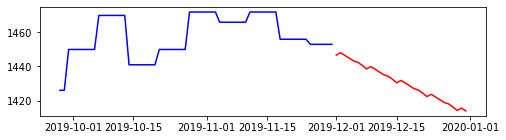

In [11]:
sku = sku_list[10]

def forecast_visualization(transactions, forecast, sku):
    data = transactions[transactions['SKU'] == sku]
    dates = pd.to_datetime(data['dates'])
    data.loc[:, ('dates')] = dates
    data = data.sort_values('dates')

    dates = list(set(data['dates'].tolist()))
    dates.sort()
    prices = [data[data['dates'] == d]['price'].mean() for d in dates]

    data = pd.DataFrame()
    data['dates'] = dates
    data['price'] = prices

    extender = pd.DataFrame()
    period = (start - data['dates'].min()).days
    extender['dates'] = [data['dates'].min() + timedelta(days=1) * n for n in range(period)]
    data0 = extender.merge(data, how='left', on='dates')

    data1 = forecast[forecast['SKU'] == sku]

    # visualize
    plt.figure(figsize=(8, 2))
    plt.plot(data0['dates'], data0['price'], color='b')
    plt.plot(data1['dates'], data1['price'], color='r')
    plt.show()
    
forecast_visualization(transactions, forecast, sku)

### Model 2: demand2price prediction

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
16:10:05 - cmdstanpy - INFO - Chain [1] start processing
16:10:05 - cmdstanpy - INFO - Chain [1] done processing
16:10:05 - cmdstanpy - INFO - Chain [1] start processing
16:10:05 - cmdstanpy - INFO - Chain [1] done processing


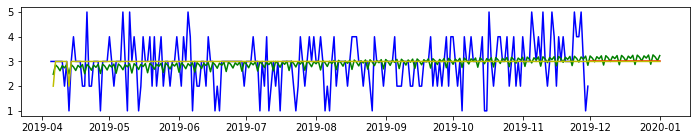

In [84]:
# create demand
ans_list = []

# for sku in tqdm(sku_list):
for _ in range(1):
    sku = sku_list[123]
    
    data = transactions[transactions['SKU'] == sku]
    dates = pd.to_datetime(data['dates'])
    data.loc[:, ('dates')] = dates
    data = data.sort_values('dates')

    dates = list(set(data['dates'].tolist()))
    dates.sort()
    qnts = [len(data[data['dates'] == d]) for d in dates]

    data = pd.DataFrame()
    data['dates'] = dates
    data['qnt'] = qnts
    
#     extender = pd.DataFrame()
#     period = (start - data['dates'].min()).days
#     extender['dates'] = [data['dates'].min() + timedelta(days=1) * n for n in range(period)]
#     data = extender.merge(data, how='left', on='dates')
    
#     data = data.interpolate()

    df0 = pd.DataFrame()
    df0['ds'] = data['dates']
    df0['y'] = data['qnt']

    df1 = pd.DataFrame()
    
    period = (start - data['dates'].max()).days + 31
    
    df1['ds'] = [data['dates'].max() + timedelta(days=1) * (n + 1) for n in range(period)]
    df1['y'] = None

    m = Prophet()
    m.fit(df0);
    forecast = m.predict(df1)
    
    df2 = pd.DataFrame()
    period2 = (start - data['dates'].min()).days + 31
    df2['ds'] = [data['dates'].min() + timedelta(days=1) * (n + 1) for n in range(period2)]
    df2['y'] = None

    m = Prophet()
    m.fit(df0);
    forecast = m.predict(df1)
    
    forecast2 = m.predict(df2)
#     qnt2 = [round(i) for i in forecast2['yhat']]
    qnt2 = forecast2['yhat']

    ans = pd.DataFrame()
    ans['dates'] = forecast['ds']
    ans['qnt'] = [round(i) for i in forecast['yhat']]
    ans['SKU'] = sku

    ans_list.append(ans)
    
forecast = pd.concat(ans_list).reset_index(drop=True)

# visualize
plt.figure(figsize=(12, 2))
plt.plot(df0['ds'], df0['y'], color='b')
plt.plot(df2['ds'], qnt2, color='g')
plt.plot(df1['ds'], ans['qnt'], color='r')
plt.plot(df2['ds'], [round(i) for i in forecast2['yhat']], color='y')
plt.show()

### Settings

In [ ]:
import ssl
import urllib.request

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

In [ ]:
UUID = uuid.uuid4().hex
print(UUID)

In [ ]:
URL_BEGIN_DATA = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/begin'
URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
URL_TASK_RESULT_POST = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result/'
URL_TASK_RESULT_GET =  'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'

### Loop

In [ ]:
def get_predicts(forecast):
    df_list = []
    req = requests.post(URL_BEGIN_DATA.format(uuid=UUID), verify=False)

    i = 0
    while True:
        response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID), verify=False)
        if type(response.json()) != str and response.json()['status'] == 'batch processing finished':
            break
        df = pd.read_json(response.json())

        # get predicts
        prices = []
        for sku, date in zip(df['SKU'].tolist(), df['dates'].tolist()):
            date = pd.to_datetime(date)
            price = forecast[(forecast['SKU'] == sku) & (forecast['dates'] == date)]['price'].mean()
            prices.append(price)
        df['price'] = prices

        df.to_json(orient='records')
        req = requests.post(URL_TASK_RESULT_POST.format(uuid=UUID),
                             data=df.to_json(orient='records'), verify=False)
        response = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID), verify=False)
        df_list.append(pd.read_json(response.json()))

        print(i)
        i+= 1
        time.sleep(1)
        
get_predicts(forecast)